# Import Package

In [129]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from skimage import io
import cv2
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Load Data

In [130]:
df = pd.read_csv(r"D:\Fourth Year SBME\ML\Breast Cancer\archive\Folds.csv")
df = df.sample(frac=1)
path = "D://Fourth Year SBME//ML//Breast Cancer//archive//BreaKHis_v1//"

df_part = df.iloc[:30000,:] # take part of data to run faster
df_part = df_part.reset_index()
df_part.shape

(30000, 5)

# preprocessing

## 1. noise removal by removing the flatten array of uncommon images

In [131]:
# remove noiise
shape = [] 
for i in tqdm(range(df_part.shape[0])):
    shape.append(io.imread(path+df_part['filename'][i]).flatten().shape[0])
    
df_part['img_shape']=shape
df_part_clean = df_part[df_part['img_shape'] == 966000] 

print(df_part.shape)
print(df_part_clean.shape)

100%|██████████| 30000/30000 [07:20<00:00, 68.08it/s](30000, 6)
(29706, 6)



## 2.color conversion & resizing preparing it for medianBlur in step 3

In [132]:
def conv_resize(img_path):
    img = cv2.imread(img_path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (28,28))
    return image

## 3. median blurring 
> **``according to openCV documentation : " for computing the median of all the pixels under the kernel window and the central pixel is replaced with this median value. This is highly effective in removing salt-and-pepper noise "``**

In [133]:
def median_Blur(img_path):
    image = conv_resize(img_path)
    image = cv2.medianBlur(image, 5)
    return image

## 4. Histogram Equalization
> **``according to openCV documentation, " improves the contrast in an image, in order to stretch out the intensity range" . This can be very helpful in our case to increase contrast in any unseen small tumor``**

In [134]:
def equalizeHist(img_path):
    image = median_Blur(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

# Visualization
>**``This function show effect of Histogram Equalization on Images``**

In [141]:
def draw_after_Processing(image_path):
    print("Image Before Applying Histogram Equalization")
    img_before=io.imread(image_path)
    f1=plt.figure(1)
    io.imshow(img_before)
    image_after=equalizeHist(image_path)
    f2=plt.figure(2)
    print("Image After Applying Histogram Equalization")

    io.imshow(image_after)
    plt.show()

Image Before Applying Histogram Equalization
Image After Applying Histogram Equalization


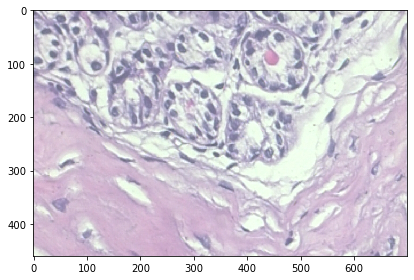

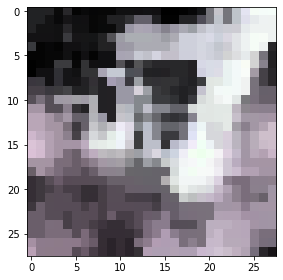

In [142]:
draw_after_Processing(path+df_part['filename'][8])

# Splitting data

In [137]:
train_image = []
y = []

for i in tqdm(range(df_part_clean.shape[0])):
    path_final = path + df_part_clean['filename'].iloc[i]
    img= equalizeHist(path_final)
    img = img/255
    train_image.append(img)
    
    if (df['filename'].iloc[i].find('benign') != -1): 
        y.append(0) 
    else:
        y.append(1)
        
X = np.array(train_image)
y = np.array(y)
print("splitting train & test .. ")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2,stratify=y )
print("splitting val & test .. ")
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=0.2,stratify=y_test )

print("categorizing .. ")
Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)
Y_val = np_utils.to_categorical(y_val, 2)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

100%|██████████| 29706/29706 [05:09<00:00, 96.03it/s]
splitting train & test .. 
splitting val & test .. 
categorizing .. 
(23764, 28, 28, 3)
(4753, 28, 28, 3)
(1189, 28, 28, 3)


# CNN Model

In [138]:
def create_model(filter_num=2 , neurons_num=10):
    model = Sequential()
    #adding conv layer with # filters = filter_num with matrix size = kernel size , padding=false(valid), and relu activation
    model.add(Conv2D(filter_num, kernel_size = (3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28, 28, 3)))
    #pooling layer to reduce the volume of the input image after convolution
    model.add(MaxPool2D(pool_size=(1,1)))
    #flatten layer to flatten the output, in preparation for the fully connected layers that make a classification decision
    model.add(Flatten())   # flatten output of conv
    #hidden layer of neurons_num neurons
    model.add(Dense(neurons_num, activation='relu'))  # hidden layer
    model.add(Dense(2, activation='softmax'))  # output layer with 2 neurons for benign & malignant
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model


# Fit
> **``Tunning = true means you will use GridsearchCV to choose between many hyperparameters combinations, Turning tunning to false means that you can take the best hyperparamers and run model directly to be faster``**

In [139]:
tunning = False
if(tunning==False):
    model = create_model(filter_num=35 , neurons_num=100)
    history = model.fit(X_train, Y_train, batch_size=10, epochs = 2, validation_data=(X_test, Y_test))
else:
    model = KerasClassifier(build_fn=create_model, verbose=10 , batch_size = 1)
    epochs = [2,5]
    filter_num = [25,35]
    neurons_num = [80,100]
    param_grid = dict(epochs=epochs,filter_num=filter_num,neurons_num=neurons_num)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, Y_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/2
2377/2377 [==============================] - 59s 25ms/step - loss: 0.6282 - accuracy: 0.6875 - val_loss: 0.6203 - val_accuracy: 0.6882
Epoch 2/2
2377/2377 [==============================] - 63s 26ms/step - loss: 0.6167 - accuracy: 0.6881 - val_loss: 0.6212 - val_accuracy: 0.6882


# predict image

Accuracy test :  68.7973086627418


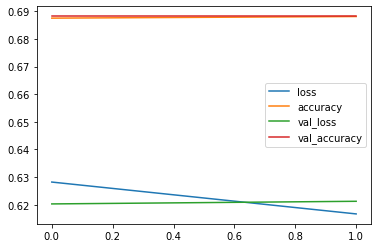

In [140]:
if(tunning==False):
    y_pred = model.predict_classes(X_val)
    history_df = pd.DataFrame(history.history)
    history_df.plot()
else:
    y_pred = grid_result.best_estimator_.predict(X_val)

acc_test = 0
for i in range(X_val.shape[0]):
    if(y_pred[i] == y_val[i]):
        acc_test= acc_test+1
print("Accuracy test : "  , acc_test/X_val.shape[0]*100)